# Compute the center of the island based on the topography

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import json
import hikinggc
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import cartopy.crs as ccrs
import contextily as ctx
import rasterio
import configparser
import matplotlib.colors as colors
from shapely import wkt
from geopy.distance import great_circle
from mycolorpy import colorlist as mcp
plt.style.use("hiking.mplstyle")
theproj = hikinggc.main_crs
datacrs = ccrs.PlateCarree()

In [11]:
import logging
logger = logging.getLogger("distance to coast")
logger.setLevel(logging.INFO)
logging.info("")

### Files and directories

In [13]:
topodir = "/home/ctroupin/data/Topography/"
topofile1 = os.path.join(topodir, '136_MDT25_GC.tif')
coastilefile = os.path.join(hikinggc.datadir, "GCcoast.dat")
coastfile2 = "../Data/Coastline/grancanaria.geojson"
os.path.exists(topofile1), os.path.exists(coastilefile)

(True, True)

## Read data
### Bathymetry 

In [14]:
if os.path.isfile(topofile1):
    topography1 = hikinggc.Topography()
    topography1.read_geotiff(topofile1)

### Coastline
#### From geoJSON

In [15]:
GC = hikinggc.Island()
GC.get_coastline(coastfile2)

lonc2 = np.array(GC.contour[0][0])
latc2 = np.array(GC.contour[1][0])
logger.info(len(latc2))

INFO:distance to coast:3727


#### From txt

In [16]:
lonc, latc = [], []
with open(coastilefile, "r") as df:
    for lines in df:
        lsplit = lines.rsplit()
        lonc.append(float(lines.split(",")[0]))
        latc.append(float(lines.split(",")[1]))
lonc = np.array(lonc)
latc = np.array(latc)
logger.info(len(latc))

INFO:distance to coast:6271


### Municipios

In [17]:
municipiosfile = os.path.join(hikinggc.datadir, "GCmunicipios.geojson")
if os.path.isfile(municipiosfile):
    logger.debug("Reading data")
    with open(municipiosfile, "r") as f:
        municipios = json.load(f)
else:
    logger.warning(f"File {municipiosfile} not there")

In [18]:
def plot_minicipios(data):
    for municipios in data["features"]:

        name = municipios['properties']['NAMEUNIT']
        logger.info("Working on {}".format(name))

        # Get the coordinates
        coords = municipios['geometry']['coordinates']

        lonall, latall = [], []
        for c1 in coords:
            lon = []
            lat = []
            for c2 in c1:
                for c3 in c2:
                    lon.append(c3[0])
                    lat.append(c3[1])
            ax.plot(lon, lat, color='k', linewidth=.2, zorder=3, transform=hikinggc.data_crs)

## Compute distance between coastline and center

In [19]:
center = (27.96193, -15.57187, 1945)
d = np.zeros_like(lonc)
for ii in range(0, len(lonc)):
    d[ii] = great_circle((latc[ii], lonc[ii]), (center[0], center[1])).km

In [20]:
mind = np.argmin(d)
maxd = np.argmax(d)
lonc[mind], latc[mind], d[mind], lonc[maxd], latc[maxd], d[maxd]

(-15.415416717529297,
 28.04736137390165,
 18.0600596484184,
 -15.407084465026799,
 28.178749084472884,
 29.0285580117604)

In [21]:
def add_legend(colordict, ax, loc=2, ncol=2, fontsize=10, legtitle=None):
    """Add a legend on the current ax using the color dictionary,
    which related a text and a color.
    
    ## Example
    
    colordict = {"< 1%": "#ffffe5",
             "1-5%": "#f7fcb9",
             "5-10%": "#d9f0a3",
             "10-15%": "#addd8e",
             "15-20%": "#78c679",
             "20-30%": "#41ab5d",
             "30-40%": "#238443",
             "> 40%": "#005a32"
            }
    """
    for k, v in colordict.items():
        ax.plot(0., 0., "s", color=v, markersize=7, label=k)
    leg = ax.legend(loc=loc, fontsize=fontsize-2, edgecolor="w", ncol=ncol)
    if legtitle is not None:
        leg.set_title(legtitle, prop={'size': fontsize})

### Create a dictionary with the ranges and colors

In [13]:
valueranges = ["18-20", "20-22", "22-24", "24-26", "26-28", "28-29"]
ncolors = len(valueranges)
cmap = plt.cm.get_cmap('RdYlGn_r', ncolors) 
norm = colors.Normalize(vmin=18., vmax=30.)
colorlist = mcp.gen_color(cmap="RdYlGn_r", n=ncolors)
colordict = dict(zip(valueranges, colorlist))
cmap.set_over(colorlist[-1])

### Read the background (tiff) files

In [6]:
backgroundfile = "../Data/Basemaps/thunderforest12.tiff"
provider = ctx.providers.Thunderforest.Outdoors

backgroundfile = "../Data/Basemaps/cartodbdark12.tiff"
provider = ctx.providers.CartoDB.DarkMatter

if os.path.isfile(backgroundfile):
    vis = hikinggc.Visible()
    vis.read_geotiff(backgroundfile)
else:
    print("not here so dowload")
    _ = ctx.bounds2raster(hikinggc.gccoords[0], hikinggc.gccoords[2], hikinggc.gccoords[1], hikinggc.gccoords[3],
                         ll=True,
                         path=backgroundfile,
                         source=provider, zoom=12)

INFO:distance to coast:Working on Agaete
INFO:distance to coast:Working on Agüimes
INFO:distance to coast:Working on Artenara
INFO:distance to coast:Working on Arucas
INFO:distance to coast:Working on Firgas
INFO:distance to coast:Working on Gáldar
INFO:distance to coast:Working on Ingenio
INFO:distance to coast:Working on Mogán
INFO:distance to coast:Working on Moya
INFO:distance to coast:Working on Las Palmas de Gran Canaria
INFO:distance to coast:Working on San Bartolomé de Tirajana
INFO:distance to coast:Working on La Aldea de San Nicolás
INFO:distance to coast:Working on Santa Brígida
INFO:distance to coast:Working on Santa Lucía de Tirajana
INFO:distance to coast:Working on Santa María de Guía de Gran Canaria
INFO:distance to coast:Working on Tejeda
INFO:distance to coast:Working on Telde
INFO:distance to coast:Working on Teror
INFO:distance to coast:Working on Valsequillo de Gran Canaria
INFO:distance to coast:Working on Valleseco
INFO:distance to coast:Working on Vega de San Ma

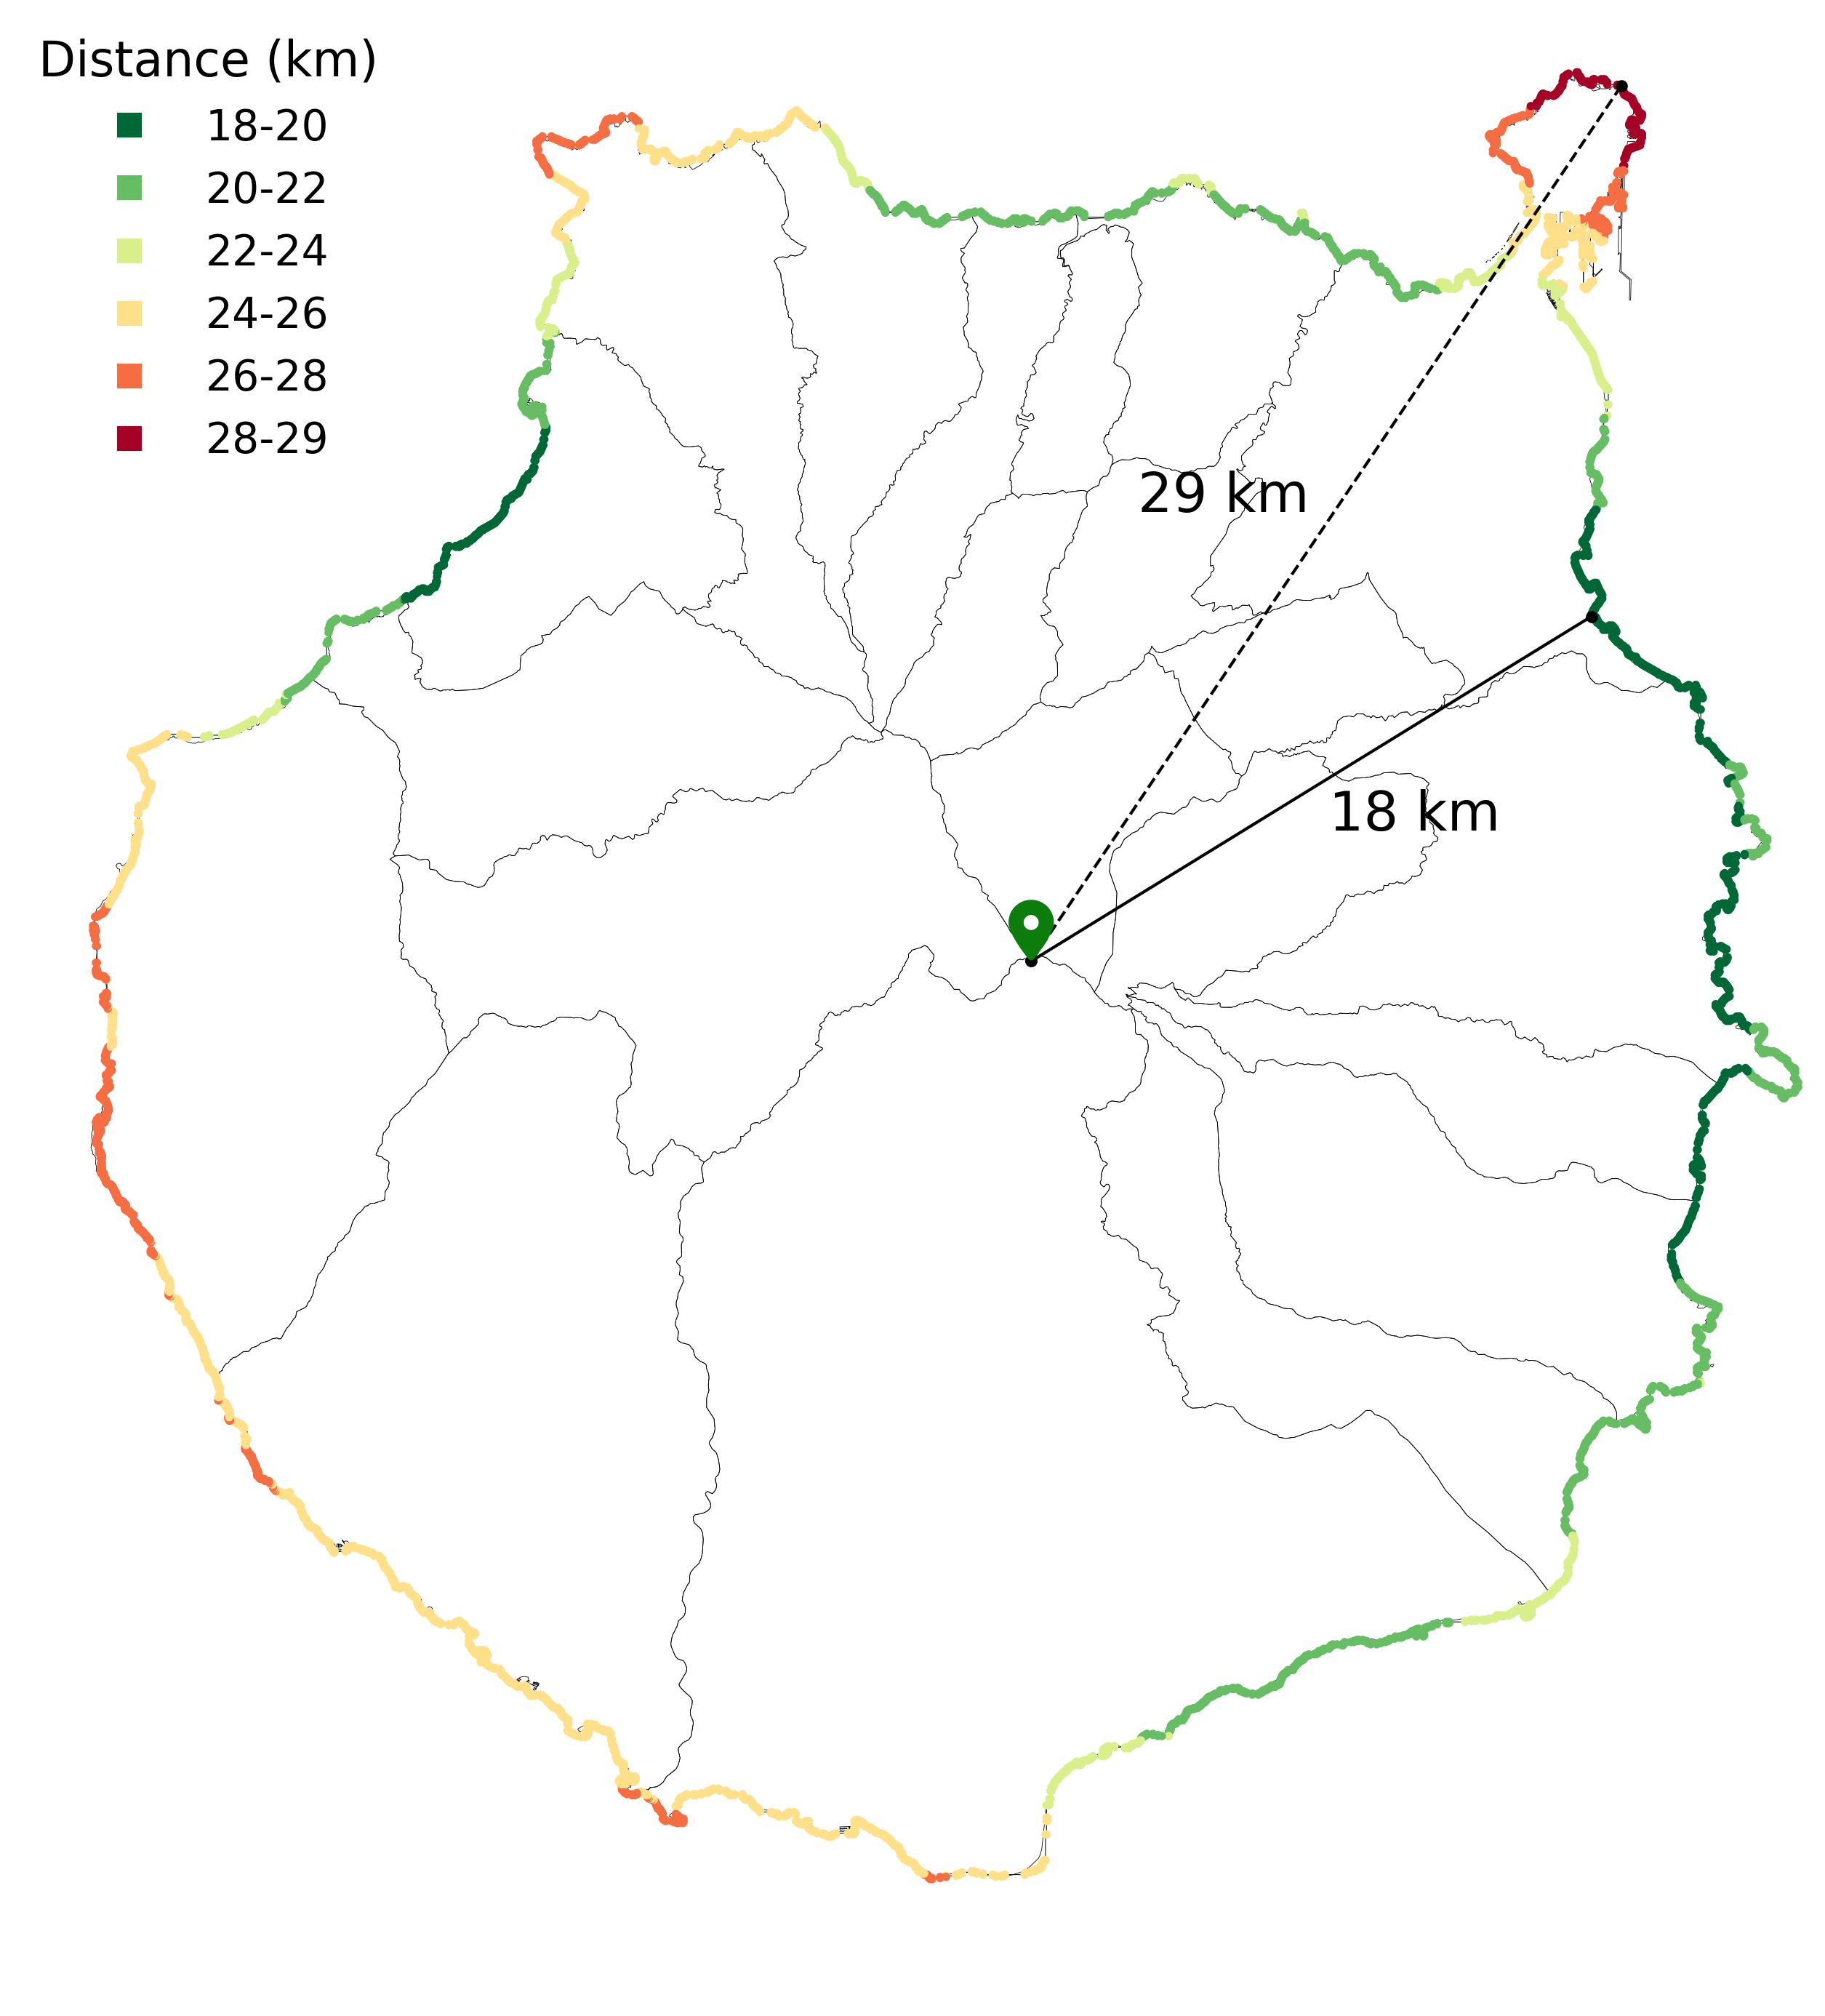

In [16]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=theproj)
ax.set_extent(hikinggc.gccoords)
ax.spines['geo'].set_color("w")

ax.plot(lonc, latc, 'k-', lw=.25, transform=hikinggc.data_crs, zorder=4)
# Add position of the center
t1 = ax.text(center[1], center[0], "\uf3c5", fontproperties=fp1, 
                 transform=hikinggc.data_crs, fontsize=20, ha="center", va="bottom", zorder=7, color="#0C7C0D")

plt.savefig(os.path.join(hikinggc.figdir, "coast2cumbre01"))
            
# Add distance and legend
#ax.imshow(vis.image, origin='upper', extent=vis.extent, transform=ccrs.epsg(3857), regrid_shape=5000, zorder=2)
scat = ax.scatter(lonc, latc, s=3, c=d, cmap=cmap, transform=hikinggc.data_crs, zorder=5)
add_legend(colordict, ax, loc=2, ncol=1, fontsize=16, legtitle="Distance (km)")

plt.savefig(os.path.join(hikinggc.figdir, "coast2cumbre02"))

# Add lines with distance
ax.plot([lonc[maxd], center[1]], [latc[maxd], center[0]], "ko--", ms=3, transform=hikinggc.data_crs, zorder=5)
ax.text(0.5 * (lonc[maxd] + center[1]), 0.5 * (latc[maxd] + center[0]), f"{int(np.round(d[maxd]))} km ", 
ha="right", va="bottom", transform=hikinggc.data_crs, fontsize=18, zorder=5)

plt.savefig(os.path.join(hikinggc.figdir, "coast2cumbre03"))

ax.plot([lonc[mind], center[1]], [latc[mind], center[0]], "ko-", ms=3, transform=hikinggc.data_crs, zorder=5)
ax.text(0.5 * (lonc[mind] + center[1]), 0.5 * (latc[mind] + center[0]), f" {int(np.round(d[mind]))} km", 
ha="left", va="top", transform=hikinggc.data_crs, fontsize=18, zorder=5)

plt.savefig(os.path.join(hikinggc.figdir, "coast2cumbre04"))

plot_minicipios(municipios)

plt.savefig(os.path.join(hikinggc.figdir, "coast2cumbre05"))


plt.show()

plt.close()

In [8]:
GPXlist = sorted(glob.glob("../GPX/Coast2cumbre/*.gpx"))

In [16]:
ifig = 100

for gpxfile in GPXlist:
    track = hikinggc.Track()
    track.get_coords(gpxfile)
    
    # Set color according to distance to Pico de las Nieves
    dist2center = great_circle((track.lat[-1], track.lon[-1]), (center[0], center[1])).km
    thecolor = cmap(norm(dist2center))
    
    # Prepare text
    track.compute_dist()
    textdistance = f"{np.round(track.dist[-1], 1)} km"
    
    
    # Make the plot
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=theproj)
    ax.set_extent(hikinggc.gccoords)
    ax.spines['geo'].set_color("w")
    ax.imshow(vis.image, origin='upper', extent=vis.extent, transform=ccrs.epsg(3857), regrid_shape=5000, zorder=2)

    ax.plot(lonc, latc, 'k-', lw=.25, transform=hikinggc.data_crs, zorder=3)
    scat = ax.scatter(lonc, latc, s=4, c=d, cmap=cmap, transform=hikinggc.data_crs, zorder=5)
    add_legend(colordict, ax, loc=2, ncol=1, fontsize=16, legtitle="Distance (km)")


    # Add position of the center
    t1 = ax.text(center[1], center[0], "\uf3c5", fontproperties=fp1, 
                     transform=hikinggc.data_crs, fontsize=20, ha="center", va="bottom", zorder=7, color="#0C7C0D")

    ax.plot(track.lon, track.lat, "-", lw=2, color=thecolor, transform=hikinggc.data_crs, zorder=3)
    ax.text(track.lon.mean(), track.lat.mean(), textdistance, color="k",
            transform=hikinggc.data_crs, fontsize=16,
           va="bottom", backgroundcolor=".95", alpha=.5, zorder=5)
    
    plt.savefig(os.path.join(hikinggc.figdir, f"coast2cumbre{str(ifig).zfill(2)}"))
    ifig += 1
    plt.close()
    
plt.show()

In [17]:
ifig = 1000
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=theproj)
ax.set_extent(hikinggc.gccoords)
ax.imshow(vis.image, origin='upper', extent=vis.extent, transform=ccrs.epsg(3857), regrid_shape=5000, zorder=2)
scat = ax.scatter(lonc, latc, s=4, c=d, cmap=cmap, transform=hikinggc.data_crs, zorder=5)
add_legend(colordict, ax, loc=2, ncol=1, fontsize=16, legtitle="Distance (km)")
t1 = ax.text(center[1], center[0], "\uf3c5", fontproperties=fp1, 
                 transform=hikinggc.data_crs, fontsize=20, ha="center", va="bottom", zorder=7, color="#0C7C0D")
plt.savefig(os.path.join(hikinggc.figdir, f"coast2cumbre{str(ifig).zfill(2)}"))
ifig += 1

for gpxfile in GPXlist:
    track = hikinggc.Track()
    track.get_coords(gpxfile)
    
    # Set color according to distance to Pico de las Nieves
    dist2center = great_circle((track.lat[-1], track.lon[-1]), (center[0], center[1])).km
    thecolor = cmap(norm(dist2center))
    
    # Prepare text
    track.compute_dist()
    textdistance = f"{np.round(track.dist[-1], 1)} km"
    
    ax.plot(track.lon, track.lat, "-", color=thecolor, transform=hikinggc.data_crs, zorder=3)
    ax.text(track.lon.mean(), track.lat.mean(), textdistance, color="k",
            transform=hikinggc.data_crs, fontsize=16,
            va="bottom", backgroundcolor=".95", alpha=.5, zorder=5)
    
plt.savefig(os.path.join(hikinggc.figdir, f"coast2cumbre{str(ifig).zfill(2)}"))
ifig += 1
plt.close()

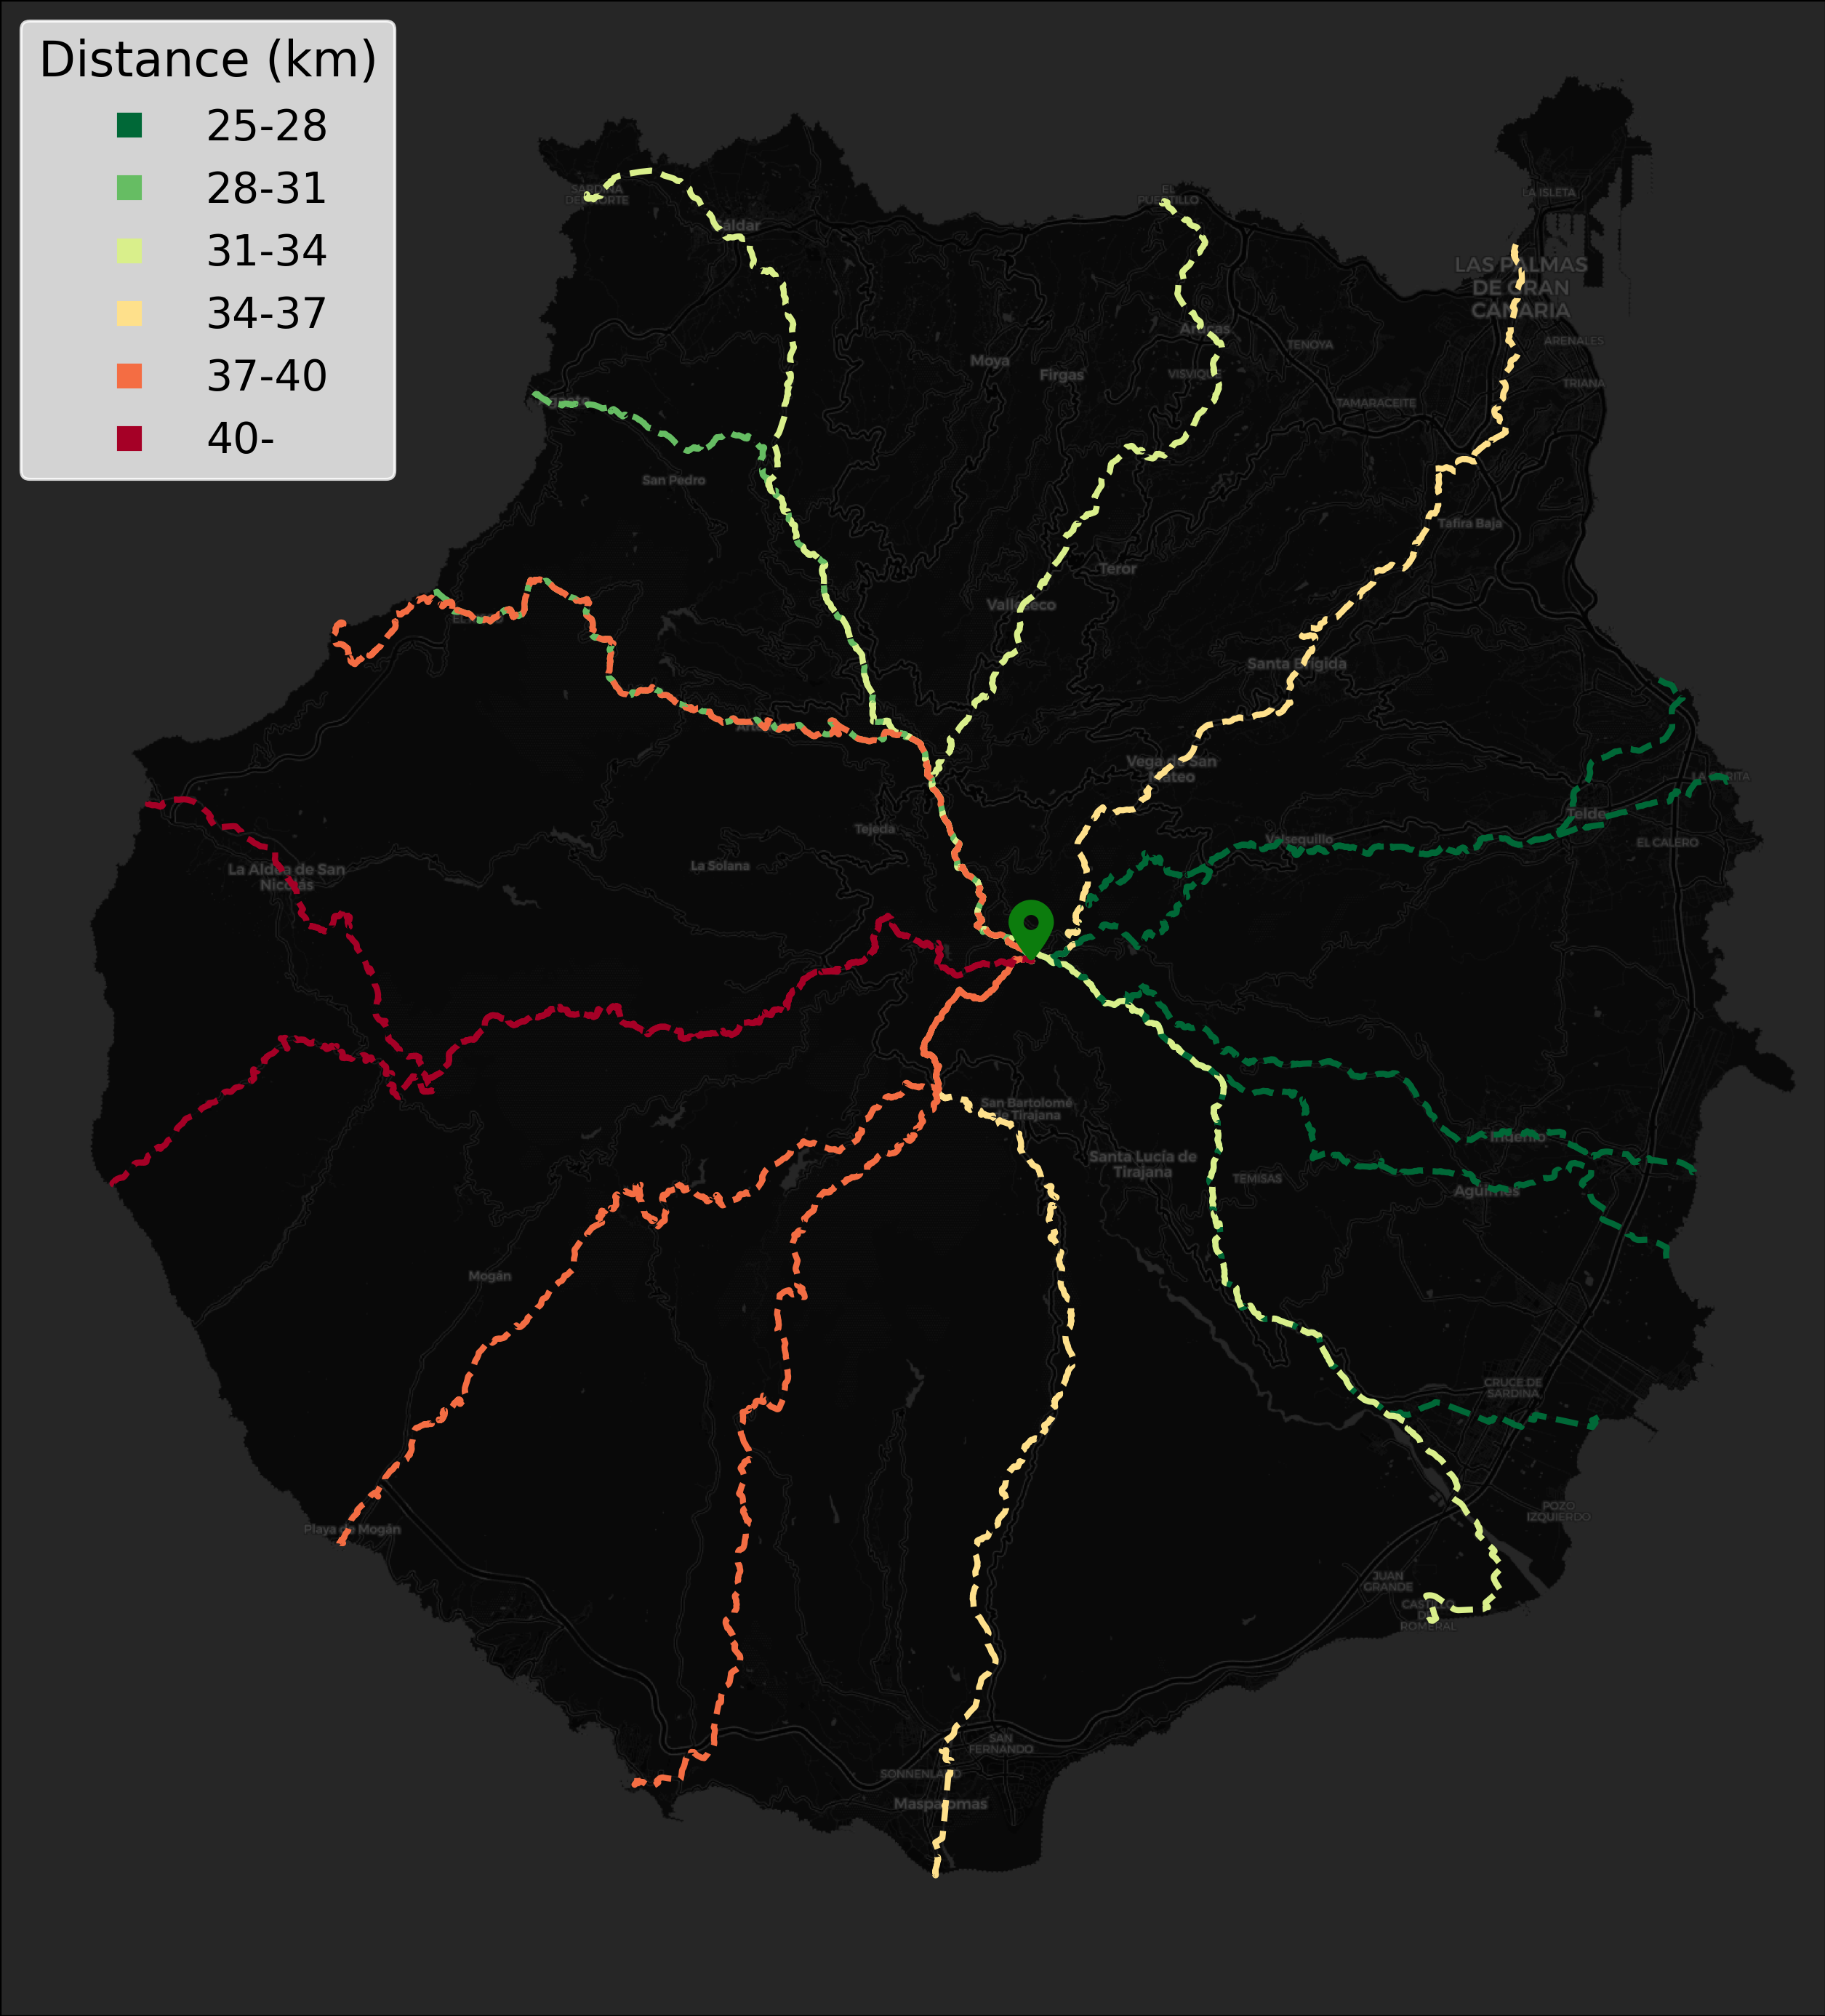

In [28]:
ifig = 1000
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=theproj)
ax.set_extent(hikinggc.gccoords)
ax.imshow(vis.image, origin='upper', extent=vis.extent, transform=ccrs.epsg(3857), regrid_shape=5000, zorder=2)
add_legend(colordict, ax, loc=2, ncol=1, fontsize=16, legtitle="Distance (km)")
t1 = ax.text(center[1], center[0], "\uf3c5", fontproperties=fp1, 
                 transform=hikinggc.data_crs, fontsize=20, ha="center", va="bottom", zorder=7, color="#0C7C0D")


for gpxfile in GPXlist:
    track = hikinggc.Track()
    track.get_coords(gpxfile)
    
    # Set color according to distance to Pico de las Nieves
    dist2center = great_circle((track.lat[0], track.lon[0]), (center[0], center[1])).km
    
    # Prepare text
    track.compute_dist()
    textdistance = f"{np.round(track.dist[-1], 1)} km"
    thecolor = cmap(norm(track.dist[-1]))
    
    ax.plot(track.lon, track.lat, "--", lw=2, color=thecolor, transform=hikinggc.data_crs, zorder=3)
    #ax.text(track.lon[0], track.lat[0], textdistance, color="k",
            #transform=hikinggc.data_crs, fontsize=14,
            #va="bottom", backgroundcolor=".95", alpha=.5, zorder=5)
    
plt.savefig(os.path.join(hikinggc.figdir, f"coast2cumbre{str(ifig).zfill(2)}"))
ifig += 1
#plt.close()

In [23]:
valueranges = ["25-28", "28-31", "31-34", "34-37", "37-40", "40-"]
ncolors = len(valueranges)
cmap = plt.cm.get_cmap('RdYlGn_r', ncolors) 
norm = colors.Normalize(vmin=25., vmax=42.)
colorlist = mcp.gen_color(cmap="RdYlGn_r", n=ncolors)
colordict = dict(zip(valueranges, colorlist))
cmap.set_over(colorlist[-1])